# Inclusion financière en Afrique

## 0. Préalable

### Importation des modules

In [101]:
# numerical calculation
import numpy as np
# dataframe
import pandas as pd
# vizualisation
import matplotlib.pyplot as plt
import seaborn as sns
# models
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# tuning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
# encoding
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import ConfusionMatrixDisplay

import random
from datetime import datetime as dt

from joblib import Parallel, delayed
import joblib

In [68]:
# Set seed for reproducability
SEED = 12
random.seed(SEED)
np.random.seed(SEED)

### Chargement du jeu de données

In [3]:
DATA_PATH = 'data/' # repertoire des données
train_set = pd.read_csv(DATA_PATH + 'Train.csv') # ensemble d'apprentissage
test_set = pd.read_csv(DATA_PATH + 'Test.csv') # ensemble de test
sample_submission = pd.read_csv(DATA_PATH + 'SampleSubmission.csv') # exemple de soumission

In [4]:
train_set.head(4)

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private


In [69]:
target = 'bank_account'

## 1. Analyse exploratoire

### 1.1. Analyse de la forme

La target de notre dataset est la variable **bank_account**.

Dimension du dataset

In [5]:
# Let’s observe the shape of our datasets.
print('Dimension du train set :', train_set.shape)
print('Dimension du test set :', test_set.shape)

Dimension du train set : (23524, 13)
Dimension du test set : (10086, 12)


Types des variables

In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


Analyse des variables qualitatives

In [7]:
train_set.select_dtypes(include='object').describe()

,country,uniqueid,bank_account,location_type,cellphone_access,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
count,23524,23524,23524,23524,23524,23524,23524,23524,23524,23524
unique,4,8735,2,2,2,2,6,5,6,10
top,Rwanda,uniqueid_1,No,Rural,Yes,Female,Head of Household,Married/Living together,Primary education,Self employed
freq,8735,4,20212,14343,17454,13877,12831,10749,12791,6437


In [8]:
for colonne in list(train_set.columns):
    print(colonne)
    print(train_set[colonne].value_counts(), '\n')

country
Rwanda      8735
Tanzania    6620
Kenya       6068
Uganda      2101
Name: country, dtype: int64 

year
2016    8735
2018    8169
2017    6620
Name: year, dtype: int64 

uniqueid
uniqueid_1       4
uniqueid_1413    4
uniqueid_1411    4
uniqueid_1410    4
uniqueid_1409    4
                ..
uniqueid_7318    1
uniqueid_7317    1
uniqueid_7316    1
uniqueid_7315    1
uniqueid_8759    1
Name: uniqueid, Length: 8735, dtype: int64 

bank_account
No     20212
Yes     3312
Name: bank_account, dtype: int64 

location_type
Rural    14343
Urban     9181
Name: location_type, dtype: int64 

cellphone_access
Yes    17454
No      6070
Name: cellphone_access, dtype: int64 

household_size
2     5229
3     3920
4     3474
1     3057
5     2853
6     2096
7     1400
8      751
9      363
10     190
11      69
12      68
13      25
15      11
14      10
16       4
21       1
18       1
17       1
20       1
Name: household_size, dtype: int64 

age_of_respondent
30     1056
35      836
25      79

Analyse des variables quantitatives

In [9]:
train_set.select_dtypes(include='number').describe()

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


Analyse des données manquantes

In [10]:
train_set.isnull().sum()

country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

Super ! Notre dataset ne contient aucune donnée manquante.

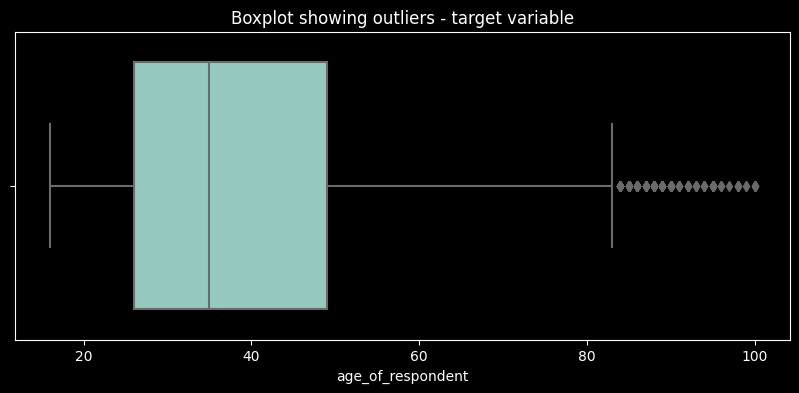

In [52]:
# Check for outliers in the target variable
plt.figure(figsize=(10, 4))
sns.boxplot(x=train_set['age_of_respondent'])
plt.title('Boxplot showing outliers - target variable')
plt.show()

Il n'y a aucun outlier dans ce dataset.

### 1.2. Analyse du fond

Analyse et visualisation de la target (bank_account)

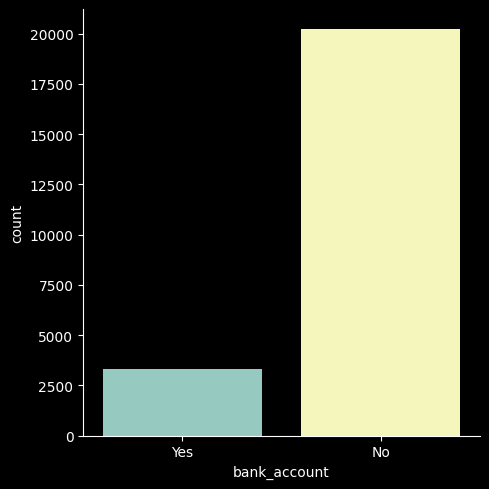

In [12]:
# explorons la distribution de la target
sns.catplot(data=train_set, x='bank_account', kind='count')
plt.show()

Compréhension des diffiérentes variables

In [13]:
variables_definitions = pd.read_csv(DATA_PATH + 'VariableDefinitions.csv') # schema de definition des variables
variables_definitions

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,The interviewee’s relationship with the head o...
9,marital_status,The martial status of the interviewee: Married...


Matrice de corrélation de toutes les variables

<Axes: title={'center': 'Corrélation des features'}>

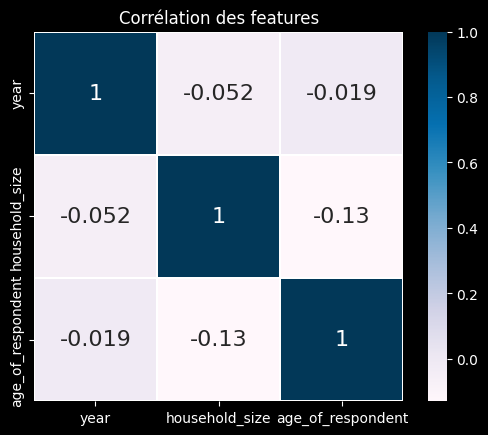

In [59]:
plt.title("Corrélation des features")
sns.heatmap(train_set.corr(numeric_only=True), linewidths=0.1, vmax=1.0, square=True, cmap=plt.cm.PuBu, linecolor="white", annot=True, annot_kws={"size": 16})

00 corrélation entre les variables du dataset

## 2. Pré-traitement

Fonction réalisant le pré-traitement de notre dataset

In [15]:
def preprocessing_data(data: pd.DataFrame, scaler) -> pd.DataFrame:
    ''' Réalise la phase de pré-traitement d'un dataset à savoir l'encodage 
    des variables discrètes et la normalisation de toutes les variables 
    '''
    # copie du dataset
    data1 = data.copy()
    # suppression de la variable d'identifiants uniques
    data1.drop('uniqueid', axis=1, inplace=True)
    # la liste des colonnes discrètes
    object_columns = list(data1.select_dtypes(include='object').columns)
    # encodage des variables discrètes
    encoder = OrdinalEncoder()
    data1[object_columns] = encoder.fit_transform(data1[object_columns])
    # normalisation
    data1[data1.columns] = scaler.fit_transform(data1)
    return data1

In [16]:
# Instantiating the scalers
MMS = MinMaxScaler()
MAS = MaxAbsScaler()
SS = StandardScaler()
RS = RobustScaler()

In [17]:
scaler = MMS
processed_train = preprocessing_data(train_set, scaler)
processed_test = preprocessing_data(test_set, scaler)
processed_test.head(3)

,country,year,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,0.0,1.0,1.0,1.0,0.105263,0.166667,1.0,0.2,0.5,0.6,0.222222
1,0.0,1.0,1.0,1.0,0.315789,0.416667,1.0,0.2,0.5,1.0,0.333333
2,0.0,1.0,0.0,0.0,0.105263,0.726190,0.0,0.8,0.5,0.0,0.888889


## 3. Modélisation

### Splitting

Séparation des features et de la target

In [18]:
X_train_pp = processed_train.drop(['bank_account'], axis=1)
y_train_pp = processed_train['bank_account']
X_train_pp.head()

,country,year,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,0.0,1.0,0.0,1.0,0.10,0.095238,0.0,1.0,0.50,0.6,1.000000
1,0.0,1.0,0.0,0.0,0.20,0.642857,0.0,0.2,1.00,0.0,0.444444
2,0.0,1.0,1.0,1.0,0.20,0.119048,1.0,0.6,0.75,1.0,1.000000
3,0.0,1.0,0.0,1.0,0.20,0.214286,0.0,0.2,0.50,0.4,0.333333
4,0.0,1.0,1.0,0.0,0.35,0.119048,1.0,0.0,0.75,0.4,0.555556


In [ ]:
X_Train, X_Val, y_Train, y_Val = train_test_split(X_train_pp, y_train_pp, test_size = 0.1, random_state=12)

### 3.1. Choix du meilleur modèle

Algorithme de recherche du meilleur modèle sans optimisation des hyperparamètres

In [60]:
GBC = GradientBoostingClassifier()
CB = CatBoostClassifier()
LGBM = LGBMClassifier()
XGB = XGBClassifier()

classifiers_list = [GBC, CB, LGBM, XGB]

In [ ]:
scores_models = {}
for model in classifiers_list:
    model.fit(X_Train, y_Train)
    y_model = model.predict(X_Val)
    metrique = 1 - accuracy_score(y_Val, y_model)
    scores_models[str(model)] = metrique
    print(f"Taux d'erreur du {str(model)} : {metrique}")

In [21]:
def index_min_value(d):
    if len(d) == 0:
        return None
    else:
        min_key = min(d, key=d.get)
        return min_key

In [67]:
index_min_value(scores_models)

'GradientBoostingClassifier()'

Le meilleur modèle parmi les modèles précédents non optimisés est donc le GBC.

### 3.2. Entrainement du modèle avec CatBoost et StratifiedKFold

In [42]:
n_skf = 5
kf = StratifiedKFold(n_skf)

params = {
    'n_estimators': 3000,
    'learning_rate': 0.1,
    'objective': 'Logloss',
    'rsm': 0.7,
    'random_seed': SEED,
    'early_stopping_rounds': 200,
    'use_best_model': True,
}

In [104]:
conts = processed_train.select_dtypes(include=np.number).columns.difference([target])

score = 0
test_oofs = []

for i, (tr_idx, vr_idx) in enumerate(kf.split(processed_train, processed_train[target])):
    X, Y = processed_train.loc[tr_idx, conts], processed_train.loc[tr_idx, target]
    x, y = processed_train.loc[vr_idx, conts], processed_train.loc[vr_idx, target]

    model_fold = CatBoostClassifier(**params)
    model_fold.fit(X, Y, eval_set=[(x, y)], verbose=50)
    p = model_fold.predict_proba(x)[:, 1]
    pred = model_fold.predict_proba(processed_test[conts])[:, 1]
    sc = log_loss(y, p, labels=[0, 1])

    score += sc/n_skf
    test_oofs.append(pred)

    print('Fold {} : {}'.format(i, sc))

print()
print()
print('Avg log : ', score)

0:	learn: 0.5959743	test: 0.6965051	best: 0.6965051 (0)	total: 14.4ms	remaining: 43.3s
50:	learn: 0.2416485	test: 0.6539133	best: 0.6305624 (28)	total: 649ms	remaining: 37.5s
100:	learn: 0.2322722	test: 0.6574714	best: 0.6305624 (28)	total: 1.28s	remaining: 36.9s
150:	learn: 0.2250358	test: 0.6602524	best: 0.6305624 (28)	total: 1.99s	remaining: 37.6s
200:	learn: 0.2186427	test: 0.6671577	best: 0.6305624 (28)	total: 2.79s	remaining: 38.9s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.6305624271
bestIteration = 28

Shrink model to first 29 iterations.
Fold 0 : 0.6305624271412505
0:	learn: 0.6091796	test: 0.6328355	best: 0.6328355 (0)	total: 35.8ms	remaining: 1m 47s
50:	learn: 0.2711874	test: 0.3295317	best: 0.3293702 (41)	total: 776ms	remaining: 44.9s
100:	learn: 0.2608766	test: 0.3282732	best: 0.3281212 (84)	total: 1.51s	remaining: 43.3s
150:	learn: 0.2531944	test: 0.3289903	best: 0.3281212 (84)	total: 2.14s	remaining: 40.4s
200:	learn: 0.2452125	test: 0.3311032	b

### 3.3. Entrainement du modèle avec CatBoost sans Kfold

In [80]:
model_cb = CatBoostClassifier(**params)
model_cb.fit(X_Train, y_Train, eval_set=[(X_Val, y_Val)], verbose=50)

y_model_cb = model_cb.predict(X_Val)
metrique = 1 - accuracy_score(y_Val, y_model_cb)
print(f"Taux d'erreur du {str(model_cb)} : {metrique}")

0:	learn: 0.5925256	test: 0.5918852	best: 0.5918852 (0)	total: 39.6ms	remaining: 1m 58s
50:	learn: 0.2733675	test: 0.2627000	best: 0.2627000 (50)	total: 736ms	remaining: 42.6s
100:	learn: 0.2642081	test: 0.2587853	best: 0.2586075 (96)	total: 1.44s	remaining: 41.3s
150:	learn: 0.2570472	test: 0.2595778	best: 0.2586075 (96)	total: 2.03s	remaining: 38.3s
200:	learn: 0.2501545	test: 0.2609333	best: 0.2586075 (96)	total: 2.66s	remaining: 37s
250:	learn: 0.2442857	test: 0.2622577	best: 0.2586075 (96)	total: 3.3s	remaining: 36.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.2586074877
bestIteration = 96

Shrink model to first 97 iterations.
Taux d'erreur du <catboost.core.CatBoostClassifier object at 0x0000017591945C60> : 0.10029749256268594


In [70]:
# choix du modèle
model = model_cb

### 3.4. Algorithme de recherche du meilleur SEED

In [22]:
scores_lgbms = []
for i in range(51):
	X_Train, X_Val, y_Train, y_Val = train_test_split(X_train_pp, y_train_pp, stratify = y_train_pp, test_size = 0.1, random_state=i)
	LGBM.fit(X_Train, y_Train)
	y_lgbm = LGBM.predict(X_Val)
	metrique = 1 - accuracy_score(y_Val, y_lgbm)
	scores_lgbms.append(metrique)
	print(i, ' - ', metrique)

50  -  0.11814704632384188
51  -  0.11984700382490443
52  -  0.10327241818954525
53  -  0.11007224819379513
54  -  0.12112197195070118
55  -  0.10029749256268594
56  -  0.11347216319592013
57  -  0.11644708882277943
58  -  0.11007224819379513
59  -  0.11474713132171699
60  -  0.11899702507437315
61  -  0.10582235444113897
62  -  0.10497237569060769
63  -  0.11049723756906082
64  -  0.1045473863153421
65  -  0.12324691882702932
66  -  0.11729706757331071
67  -  0.1206969825754356
68  -  0.10922226944326396
69  -  0.11474713132171699
70  -  0.10879728006799827
71  -  0.12197195070123246
72  -  0.11814704632384188
73  -  0.11219719507012327
74  -  0.11092222694432641
75  -  0.11559711007224815
76  -  0.11092222694432641
77  -  0.11092222694432641
78  -  0.11942201444963874
79  -  0.11474713132171699
80  -  0.12027199320017001
81  -  0.10624734381640455
82  -  0.11177220569485757
83  -  0.11049723756906082
84  -  0.10964725881852955
85  -  0.11559711007224815
86  -  0.1079473013174671
87  

Nouveau seed après recherche du meilleur

In [30]:
# Set seed for reproducability
SEED = 12
random.seed(SEED)
np.random.seed(SEED)

### 3.5. Matrice de confusion

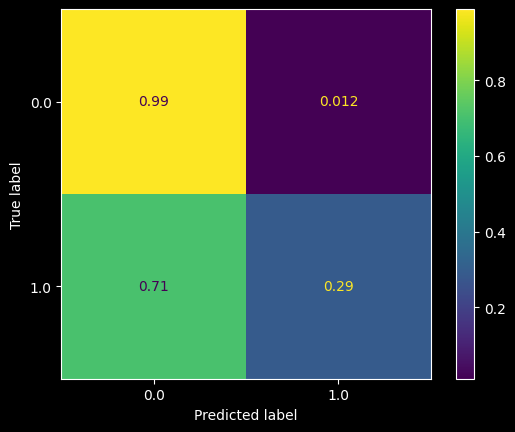

In [105]:
# traçons la matrice de confusion pour le modèle
ConfusionMatrixDisplay.from_estimator(model_fold, X_Val, y_Val, normalize='true')
plt.show()

Cette matrice montre que notre modèle reconnaît mieux les vrais négatifs (l'individu n'a pas de compte bancaire) par rapport aux vrais positifs (l'individu a un compte bancaire). Cela était prévisible car il y a 6 fois plus de négatifs que de positifs dans le dataset.

### 3.6. Optimisation avec GridSearchCV

Soit la liste des hyperparamètres valides pour l'estimateur GradientBoostingClassifier() : ['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start']

In [ ]:
params_grid: dict[str, tuple] = {
    'random_state': (0, 12, 42, 55),
    'n_estimators': (100, 150, 200),
    'max_depth': (3, 5, 8),
    'min_samples_leaf': (4, 6, 8),
    'min_samples_split': (4, 8)
}
grid_cv = GridSearchCV(LGBM, params_grid, n_jobs=-1, verbose=2, cv=3)
grid_cv.fit(X_Train, y_Train)

In [ ]:
optimized_model = GradientBoostingClassifier(
    max_depth=grid_cv.best_params_['max_depth'], 
	min_samples_leaf=grid_cv.best_params_['min_samples_leaf'], 
	min_samples_split=grid_cv.best_params_['min_samples_split'], 
	n_estimators=grid_cv.best_params_['n_estimators'], 
	random_state=grid_cv.best_params_['random_state']
)

optimized_model.fit(X_Train, y_Train)
y_pred = optimized_model.predict(X_Val)

print("Taux d'erreur de LGBMClassifier : ", 1 - accuracy_score(y_Val, y_pred))
# 0.10114747131321722

Taux d'erreur de LGBMClassifier :  0.10327241818954525


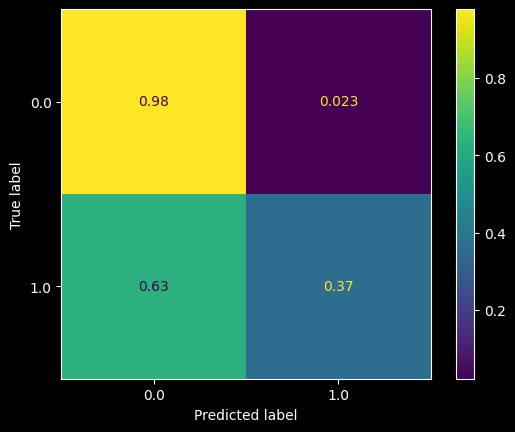

In [46]:
# traçons la matrice de confusion pour le GBC
# ConfusionMatrixDisplay.from_estimator(optimized_model, X_Val, y_Val, normalize='true')
ConfusionMatrixDisplay.from_estimator(model_cb_2, X_Val, y_Val, normalize='true')
plt.show()

## 4. Prédiction

Après avoir choisi un modèle, réalisons maintenant les prédictions sur notre ensemble de test.

In [106]:
try:
	processed_test.drop(['bank_account'], axis=1, inplace=True)
except:
	pass

Nouveau modèle après optimisation des hyperparamètres

In [ ]:
model = model

In [107]:
test_set['bank_account'] = model_fold.predict(processed_test)
test_set.head(5)

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,bank_account
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government,1.0
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private,1.0
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent,0.0
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent,0.0
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent,0.0


## 5. Soumission

Visualisation du fichier de soumission

In [ ]:
sample_submission.head()

Création de notre fichier de soumission

In [109]:
soumissions = pd.DataFrame(
    {"unique_id": test_set["uniqueid"] + " x " + test_set["country"], "bank_account": test_set['bank_account'].astype(int)})
soumissions.to_csv(
    f'submissions/soumission_{dt.now().strftime(format="%Y-%m-%d_%Hh%M")}.csv', index=False)

In [110]:
soumissions

,unique_id,bank_account
0,uniqueid_6056 x Kenya,1
1,uniqueid_6060 x Kenya,1
2,uniqueid_6065 x Kenya,0
3,uniqueid_6072 x Kenya,0
4,uniqueid_6073 x Kenya,0
...,...,...
10081,uniqueid_2998 x Uganda,0
10082,uniqueid_2999 x Uganda,0
10083,uniqueid_3000 x Uganda,0
10084,uniqueid_3001 x Uganda,0


## 6. Sauvegarde du modèle

In [78]:
# Save the model as a pickle in a file
joblib.dump(model, 'models/catboost_10.8962918.pkl')

['models/catboost_10.8962918.pkl']